### Examples of Ghost coherence and other oddities

In [1]:
import os
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn.conn_spec import conn_spec
from tqdm import tqdm
from xfrites.conn.conn_tf import wavelet_spec

import GDa.graphics.plot as plot
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

#### Loading data

In [3]:
# Instantiate class
ses = session(
    raw_path="../GrayLab/",
    monkey="lucy",
    date="141024",
    session=1,
    slvr_msmod=False,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
)

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1], behavioral_response=[1])

In [4]:
#### Surrogate data
n_surr = 1
data_surr = []
for i in range(n_surr):
    data_surr += [trial_swap_surrogates(data, seed=i + 500, verbose=False)]

### Time-resolved coherence

In [5]:
# Spectral analysis parameters

sm_times = 0.3  # In seconds
sm_freqs = 1
sm_kernel = "square"

# Defining parameters
decim = 20  # Downsampling factor
mode = "multitaper"  # Wheter to use Morlet or Multitaper

n_freqs = 100  # How many frequencies to use
freqs = np.linspace(3, 75, n_freqs)  # Frequency array
n_cycles = freqs / 4  # Number of cycles
mt_bandwidth = None

In [6]:
def get_channels_indexes(labels, channels):
    """Given the channel label (channels) return its index"""
    idx = []
    for i in range(len(labels)):
        if labels[i] in channels:
            idx += [i]
    return idx

In [7]:
# Labels of the indexes
labels = data.attrs["channels_labels"]

#### Example channels with large beta power peaks

- Area F2 (chns 36)
- Area F1 (chns 63, 69, 73, 83, 84, 92, 95, 105)
- Area 3 (chns 64, 65, 66, 106, 117)

In [8]:
channels = np.array([36, 63, 69, 73, 83, 84, 92, 95, 105, 64, 65, 66, 106, 117])
idx = get_channels_indexes(labels, channels)

In [9]:
sxx = wavelet_spec(
    data.isel(roi=idx),
    freqs,
    roi="roi",
    times="time",
    sm_times=0,
    sm_freqs=0,
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
)

Compute auto- and cross-spectra (n_freqs=100, decim=20, sm_times=1, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   4 out of  13 | elapsed:   21.8s remaining:   48.9s
[Parallel(n_jobs=40)]: Done   7 out of  13 | elapsed:   23.4s remaining:   20.1s
[Parallel(n_jobs=40)]: Done  10 out of  13 | elapsed:   25.1s remaining:    7.5s
[Parallel(n_jobs=40)]: Done  13 out of  13 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done  13 out of  13 | elapsed:   26.9s finished


##### Trial-averaged power 

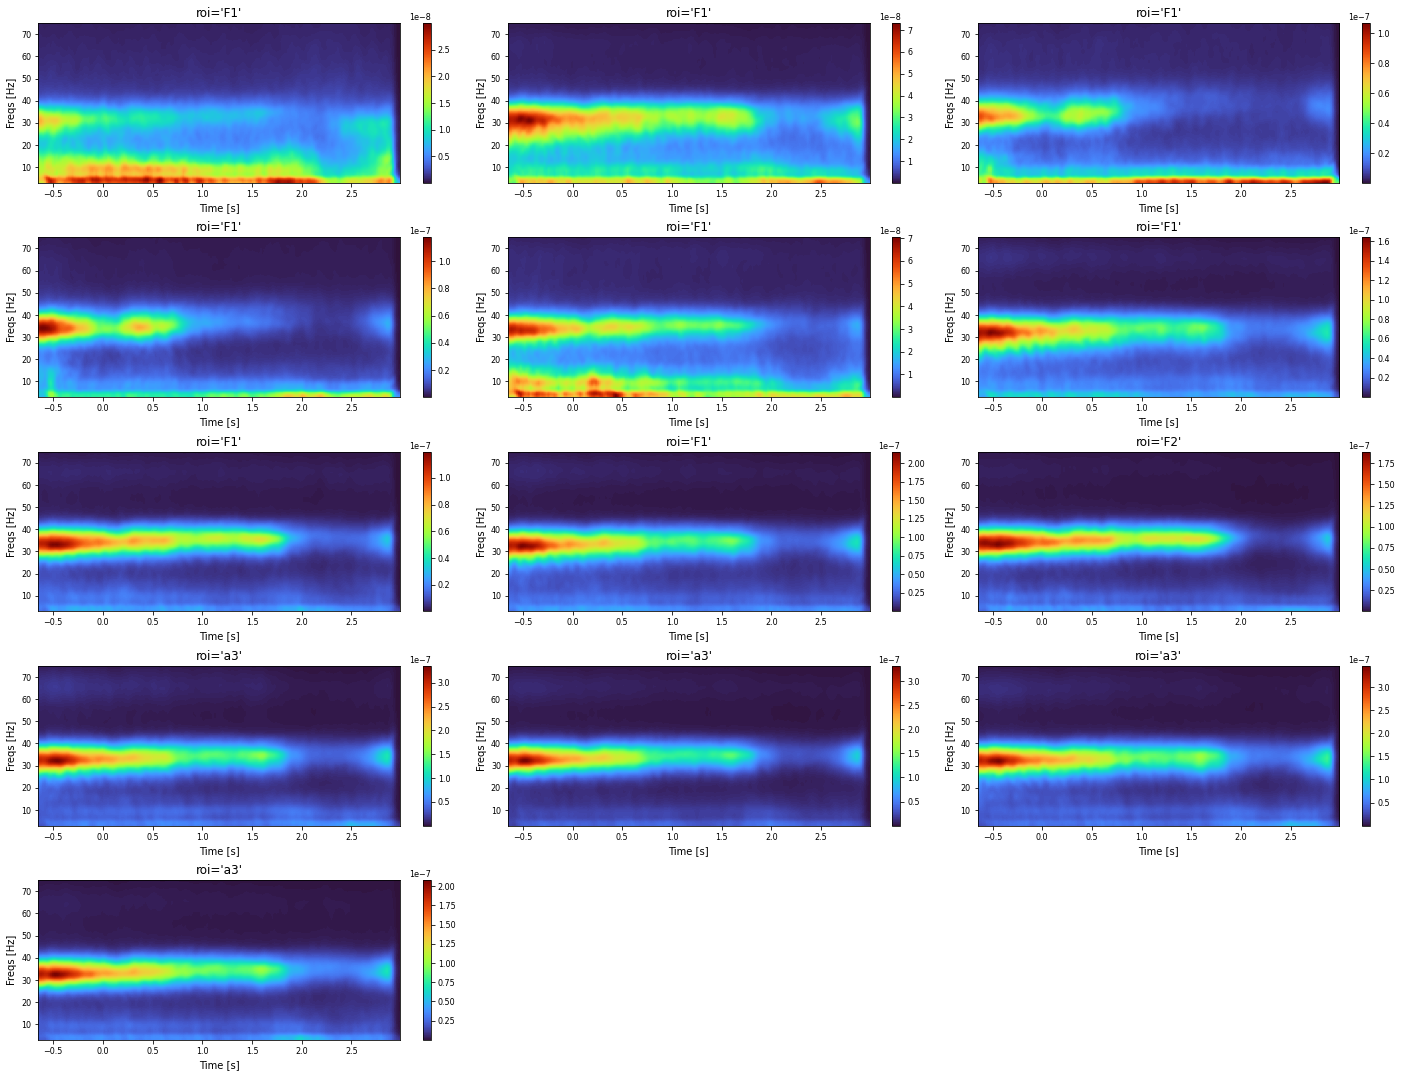

In [10]:
rois = np.sort(sxx.roi.data)
extent = [sxx.times.data[0], sxx.times.data[-1], sxx.freqs.data[0], sxx.freqs.data[-1]]
plt.figure(figsize=(20, 15))
for i, roi in enumerate(rois):
    plt.subplot(5, 3, i + 1)
    plt.imshow(
        sxx.isel(roi=i).mean("trials"),
        aspect="auto",
        cmap="turbo",
        origin="lower",
        extent=extent,
    )
    plt.title(f"{roi=}", fontsize=BIGGER_SIZE)
    plt.ylabel("Freqs [Hz]")
    plt.xlabel("Time [s]")
    plt.colorbar()
plt.tight_layout()

##### Single-trial power

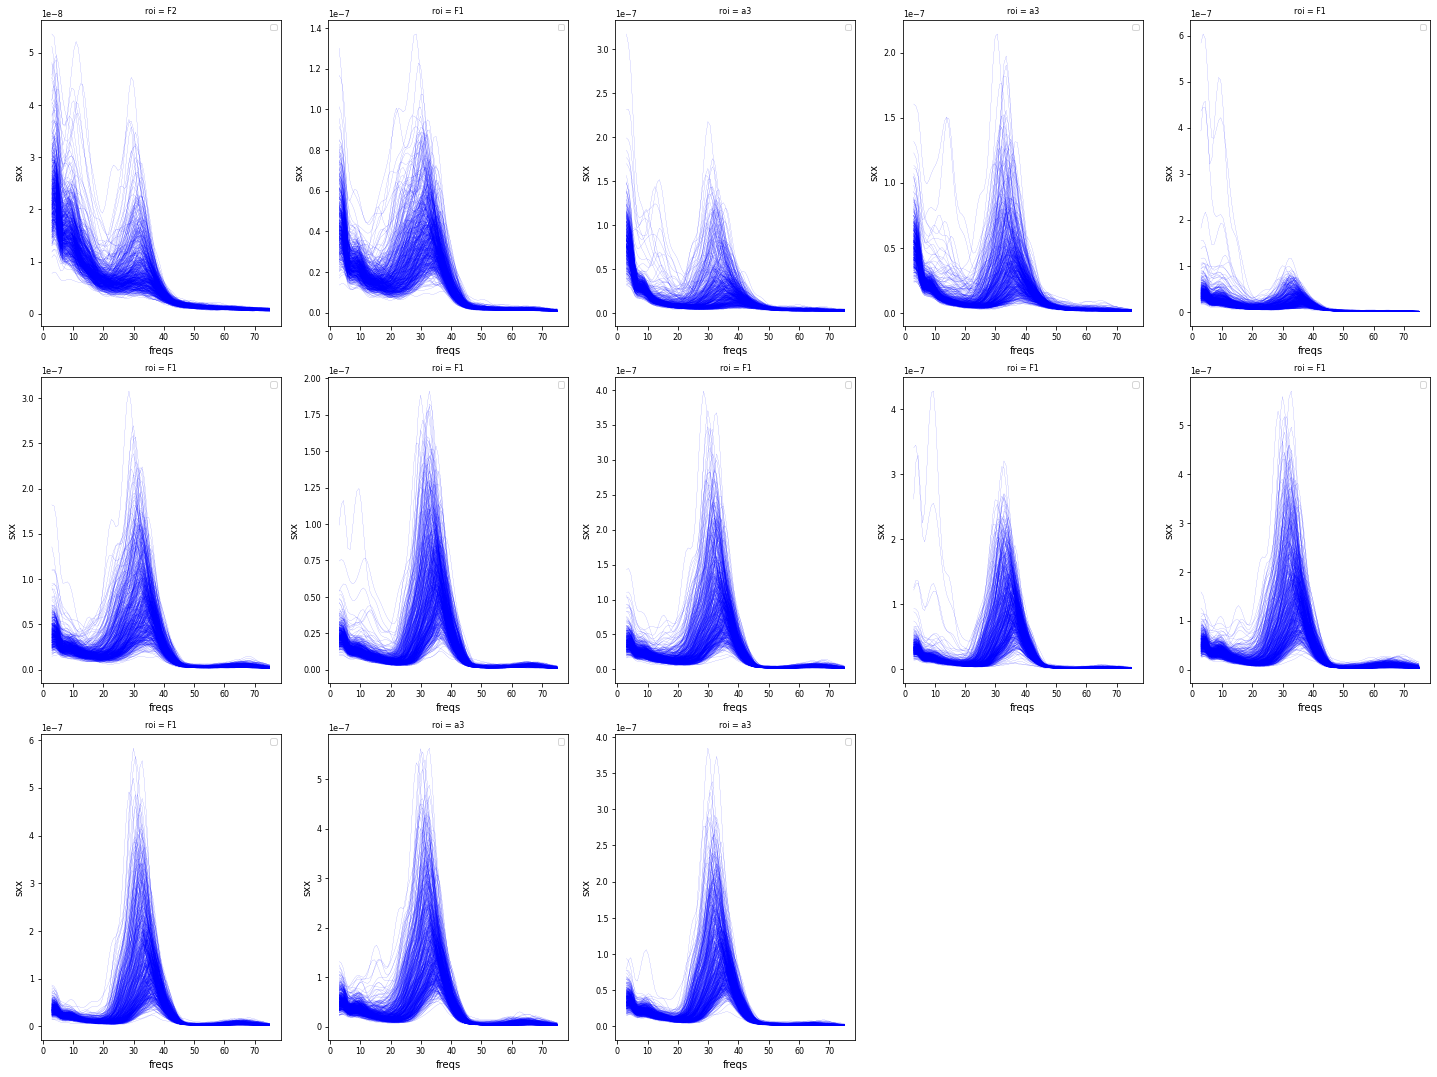

In [11]:
beta_power = sxx.mean("times")
plt.figure(figsize=(20, 15))
count = 1
for i, roi in enumerate(rois):
    plt.subplot(3, 5, count)
    beta_power.isel(roi=i).plot(x="freqs", hue="trials", color="b", lw=0.1)
    count += 1
    plt.legend([])
plt.tight_layout()

#### Ghost coherence with chn 236 (V1)

- 36-236
- 63-236
- 66-236
- 69-236
- 73-236
- 83-236
- 84-236
- 92-236
- 95-236
- 105-236
- 106-236
- 117-236

In [12]:
channels = np.array([36, 63, 66, 69, 73, 83, 84, 92, 95, 105, 106, 117])
V1_idx = get_channels_indexes(labels, [236])
idx = get_channels_indexes(labels, channels)
pairs = np.vstack((idx, V1_idx * len(idx))).T

##### V1 power at single trial

In [13]:
V1_power = sxx = wavelet_spec(
    data.isel(roi=[36, 76]),
    freqs,
    roi="roi",
    times="time",
    sm_times=0,
    sm_freqs=0,
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
)

Compute auto- and cross-spectra (n_freqs=100, decim=20, sm_times=1, sm_freqs=1)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:   12.6s finished


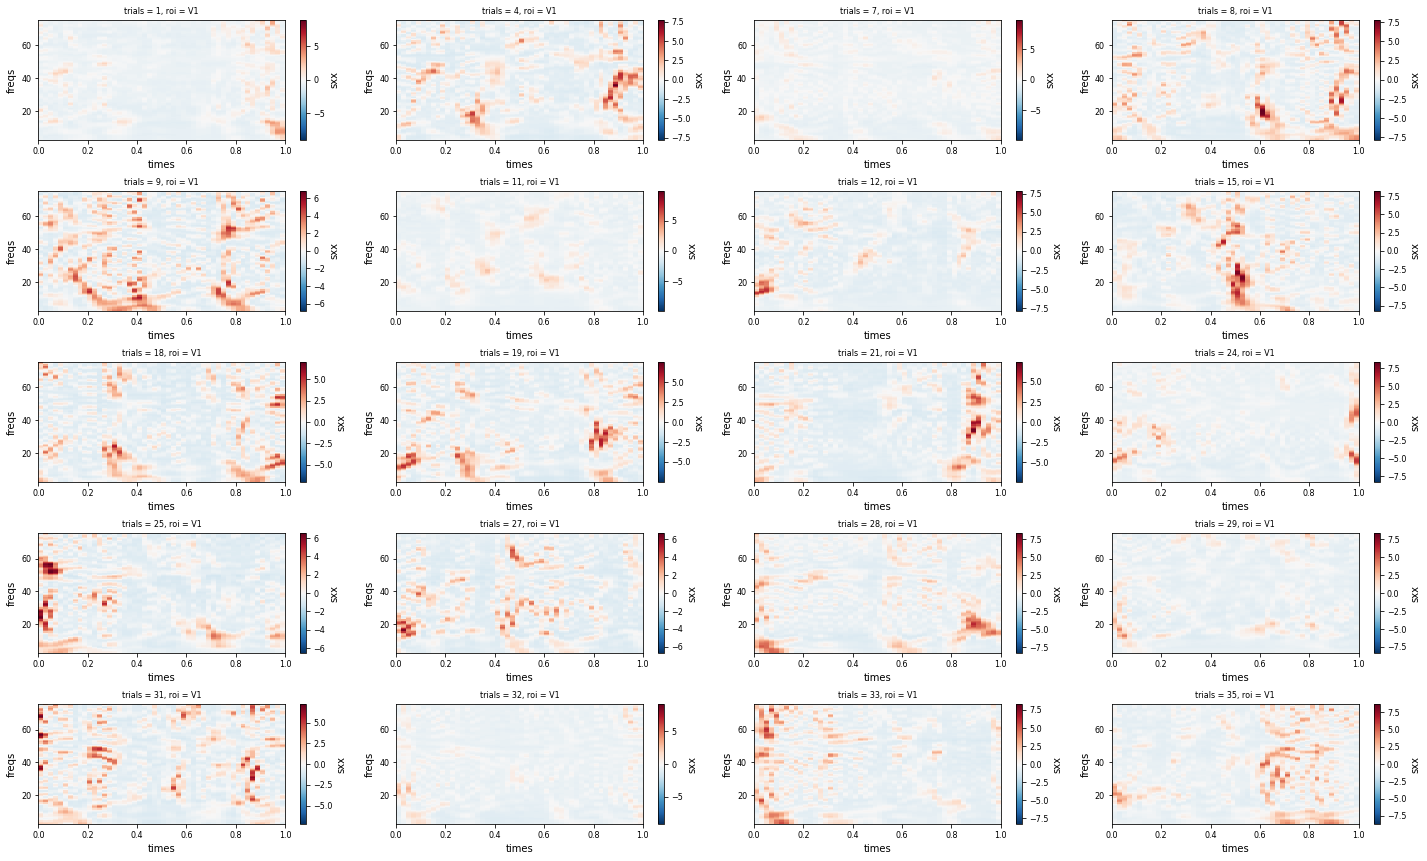

In [14]:
plt.figure(figsize=(20, 12))
Z = (V1_power - V1_power.mean("times")) / V1_power.std("times")
for i in range(20):
    plt.subplot(5, 4, i + 1)
    Z.isel(roi=1, trials=i).plot.imshow(x="times", y="freqs", cmap="RdBu_r")
    plt.xlim(0, 1)
plt.tight_layout()

In [15]:
kw = dict(
    freqs=freqs,
    times="time",
    roi="roi",
    foi=None,
    n_jobs=20,
    pairs=pairs,
    mode=mode,
    n_cycles=n_cycles,
    decim=decim,
    metric="coh",
    sm_kernel=sm_kernel,
    sm_times=sm_times,
    sm_freqs=sm_freqs,
    block_size=1,
    mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=12, n_freqs=100, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.4min remaining:    3.4s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.5min finished


  0%|          | Estimating pairwise Coherence for trials 0...581 : 0/12 [00:00<?,       ?it/s]

In [16]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr):
    coh_surr += [conn_spec(data_surr[i], **kw)]
coh_surr = xr.concat(coh_surr, dim="seeds")

Computing pairwise Coherence (n_pairs=12, n_freqs=100, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.4min remaining:    3.5s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.5min finished


  0%|          | Estimating pairwise Coherence for trials 0...581 : 0/12 [00:00<?,       ?it/s]

In [17]:
# Compute threshold
thr = coh_surr.isel(seeds=0).quantile(0.95, dim="trials")
# Eliminating non-siginificant values
coh_sig = coh * (coh >= thr)

##### Trial-averaged coherence

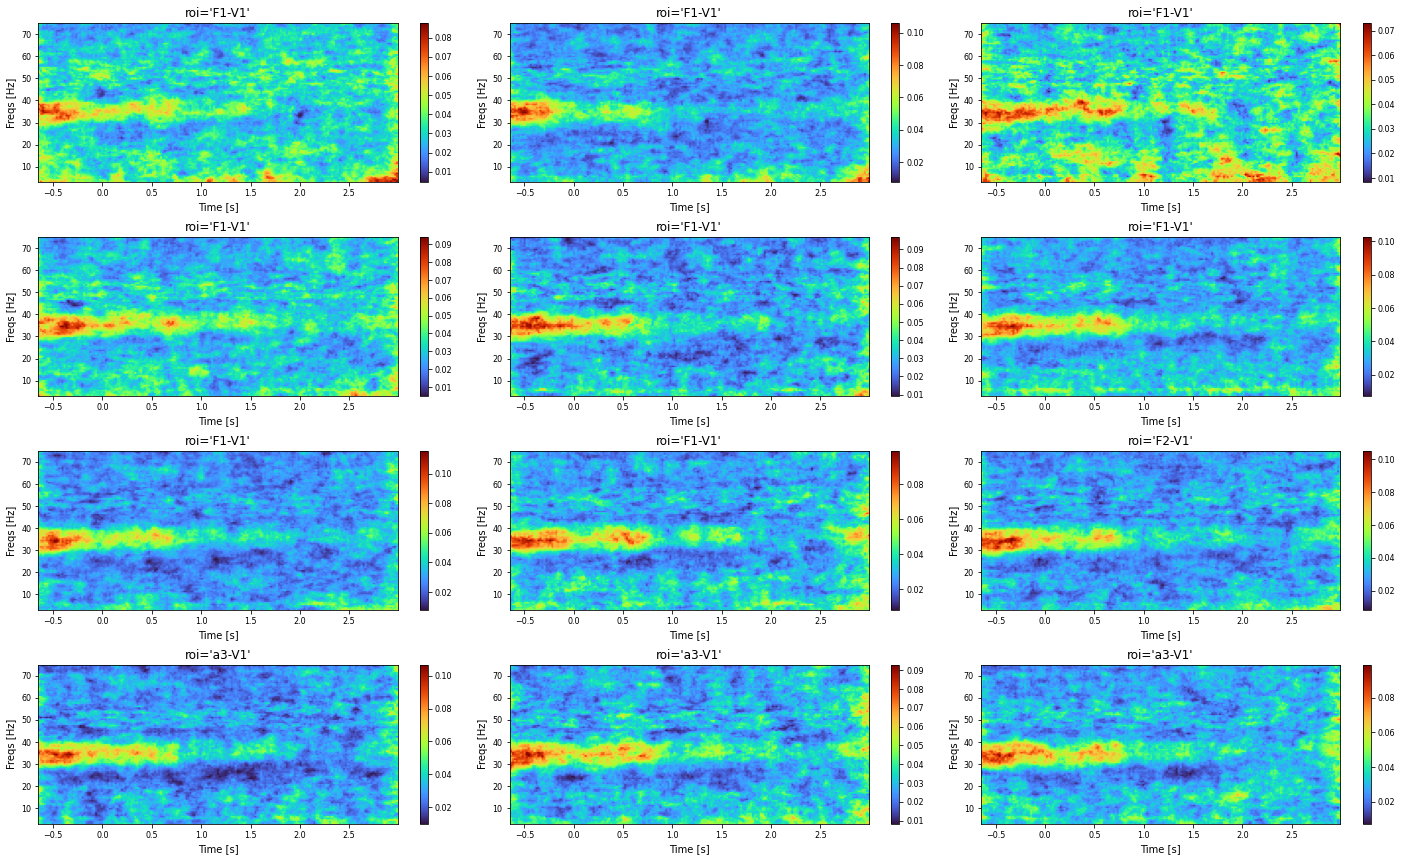

In [18]:
rois = np.sort(coh_sig.roi.data)
extent = [
    coh_sig.times.data[0],
    coh_sig.times.data[-1],
    coh_sig.freqs.data[0],
    coh_sig.freqs.data[-1],
]
plt.figure(figsize=(20, 12))
for i, roi in enumerate(rois):
    plt.subplot(4, 3, i + 1)
    plt.imshow(
        coh_sig.isel(roi=i).mean("trials"),
        aspect="auto",
        cmap="turbo",
        origin="lower",
        extent=extent,
    )
    plt.title(f"{roi=}", fontsize=BIGGER_SIZE)
    plt.ylabel("Freqs [Hz]")
    plt.xlabel("Time [s]")
    plt.colorbar()
plt.tight_layout()

##### Single-trial coherence

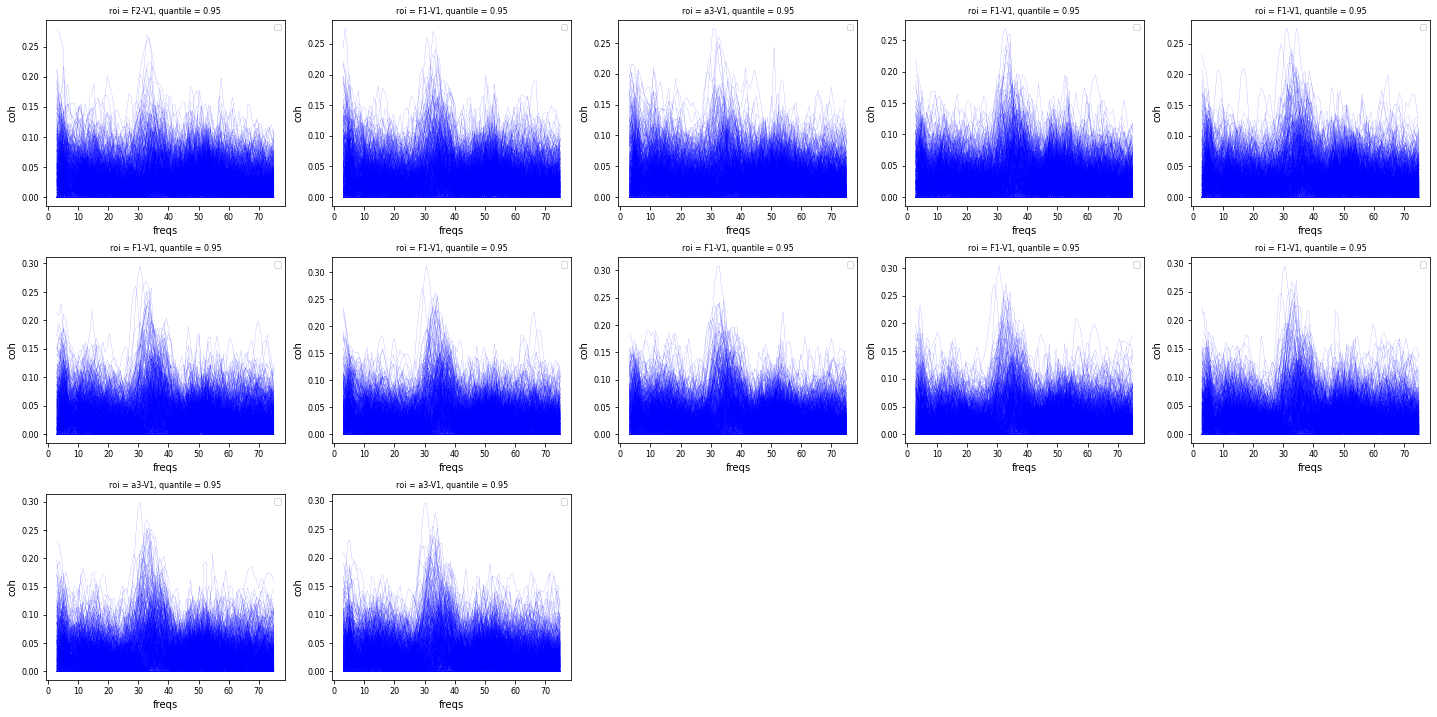

In [19]:
plt.figure(figsize=(20, 10))
count = 1
for i in range(coh_sig.sizes["roi"]):
    plt.subplot(3, 5, count)
    coh_sig.mean("times").isel(roi=i).plot(x="freqs", hue="trials", color="b", lw=0.1)
    count += 1
    plt.legend([])
plt.tight_layout()

##### Trial-averaged PLV

In [20]:
kw["metric"] = "plv"
plv = conn_spec(data, **kw)
plv_surr = conn_spec(data_surr[0], **kw)

Computing pairwise Phase-Locking Value (n_pairs=12, n_freqs=100, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.4min remaining:    3.4s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.5min finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...581 : 0/12 [00:00<?,       ?it/s]

Computing pairwise Phase-Locking Value (n_pairs=12, n_freqs=100, decim=20, sm_times=15, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done  75 out of  78 | elapsed:  1.5min remaining:    3.5s
[Parallel(n_jobs=20)]: Done  78 out of  78 | elapsed:  1.5min finished


  0%|          | Estimating pairwise Phase-Locking Value for trials 0...581 : 0/12 [00:00<?,       ?it/s]

In [21]:
# Compute threshold
thr_plv = plv_surr.quantile(0.95, dim="trials")
# Eliminating non-siginificant values
plv_sig = plv * (plv >= thr_plv)

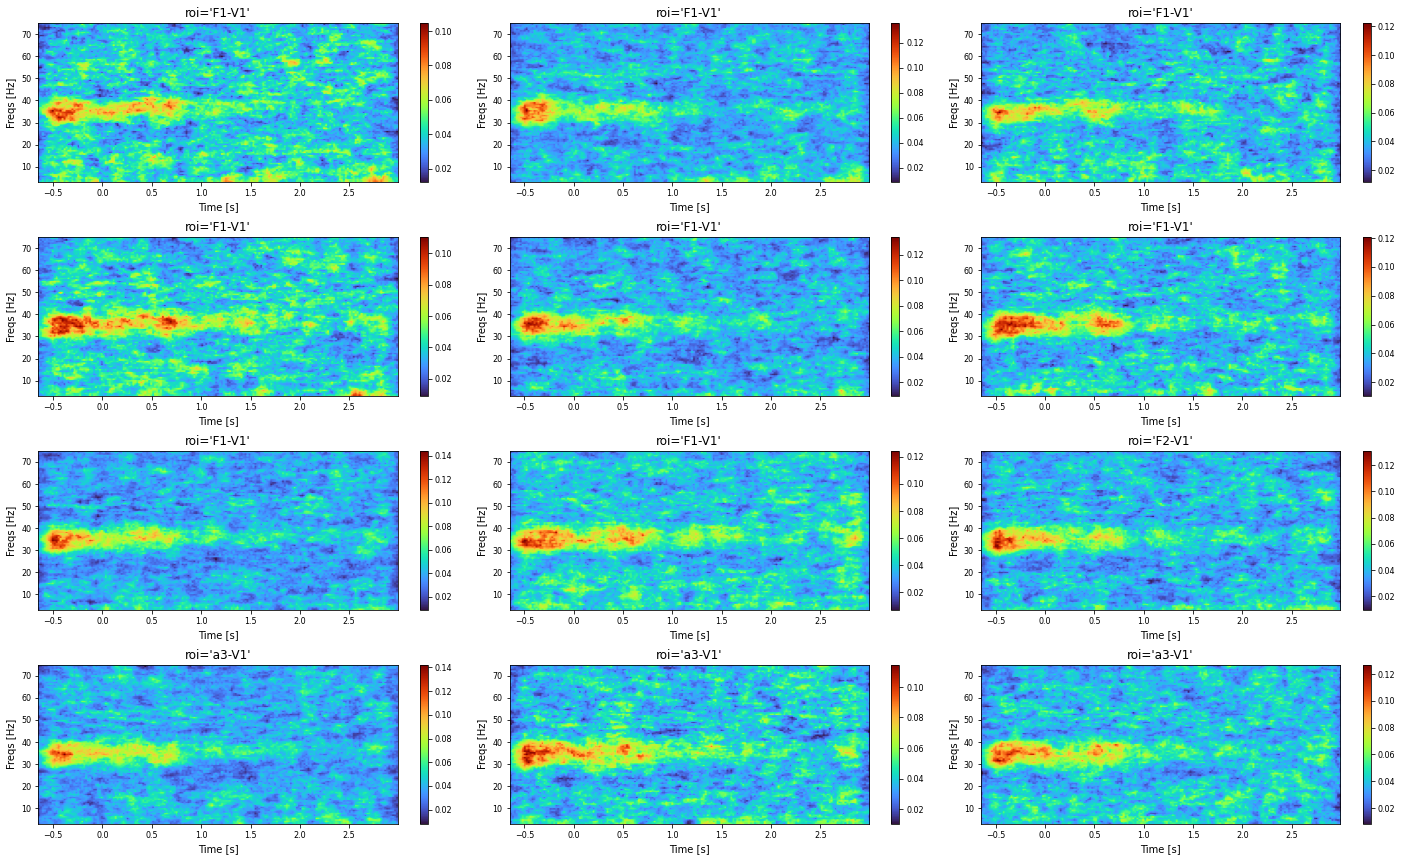

In [22]:
rois = np.sort(coh_sig.roi.data)
extent = [
    coh_sig.times.data[0],
    coh_sig.times.data[-1],
    coh_sig.freqs.data[0],
    coh_sig.freqs.data[-1],
]
plt.figure(figsize=(20, 12))
for i, roi in enumerate(rois):
    plt.subplot(4, 3, i + 1)
    plt.imshow(
        plv_sig.isel(roi=i).mean("trials"),
        aspect="auto",
        cmap="turbo",
        origin="lower",
        extent=extent,
    )
    plt.title(f"{roi=}", fontsize=BIGGER_SIZE)
    plt.ylabel("Freqs [Hz]")
    plt.xlabel("Time [s]")
    plt.colorbar()
plt.tight_layout()